## Stock Price Forecasing Using ARIMA Methods - Model Training and Evaluation

### Setup

#### Import packages

In [44]:
import os
import joblib
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from scipy import stats
import warnings
import joblib
warnings.filterwarnings('ignore')

# Set figure size for plots
rcParams['figure.figsize'] = 12, 6

#### Load data

In [45]:
data_dir_path = '../../data/preprocessed/final-phase'

# List of products to process
products = ['P001', 'P002', 'P003', 'P004', 'P007', 'P012']

# Dictionary to store product dataframes
product_data = {}

# Load selling and cost price data for each product
for product_id in products:
    product_dir = os.path.join(data_dir_path, product_id)
    
    # Load selling price data
    selling_file = os.path.join(product_dir, 'selling_price_stationary.csv')
    selling_df = pd.read_csv(selling_file, index_col='Date', parse_dates=True)
    
    # Load cost price data
    cost_file = os.path.join(product_dir, 'cost_price_stationary.csv')
    cost_df = pd.read_csv(cost_file, index_col='Date', parse_dates=True)
    
    product_data[product_id] = {
        'selling': selling_df,
        'cost': cost_df
    }
print("Loaded product price data")

Loaded product price data


In [46]:
product_data

{'P001': {'selling':             selling price
  Date                     
  2022-01-03            0.0
  2022-01-03            0.0
  2022-01-03            0.0
  2022-01-06            3.0
  2022-01-08           -3.0
  ...                   ...
  2025-04-26            0.0
  2025-04-26            5.0
  2025-04-28            0.0
  2025-04-29            0.0
  2025-06-17           30.0
  
  [1255 rows x 1 columns],
  'cost':             cost price
  Date                  
  2022-01-03         0.0
  2022-01-03         0.0
  2022-01-03         0.0
  2022-01-06         0.0
  2022-01-08         0.0
  ...                ...
  2025-04-26         0.0
  2025-04-26         0.0
  2025-04-28         0.0
  2025-04-29         0.0
  2025-06-17        35.0
  
  [1255 rows x 1 columns]},
 'P002': {'selling':             selling price
  Date                     
  2022-01-03            0.0
  2022-01-03            0.0
  2022-01-03            0.0
  2022-01-06            6.0
  2022-01-08           -6.0
  ...   

In [48]:
# Load product statistics and include last values from original series
stats_file = os.path.join(data_dir_path, 'product_statistics.joblib')
product_stats = joblib.load(stats_file)

print("\nProduct Statistics:")
pprint(product_stats)


Product Statistics:
{'P001': {'cost': {'last_value': 390.0,
                   'mean': 420.5015923566879,
                   'std': 79.65405278422698},
          'selling': {'last_value': 420.0,
                      'mean': 473.2300955414013,
                      'std': 90.3363193821443}},
 'P002': {'cost': {'last_value': 58.0,
                   'mean': 66.82398619499568,
                   'std': 15.706727522007455},
          'selling': {'last_value': 78.0,
                      'mean': 81.17601380500432,
                      'std': 16.802368787679434}},
 'P003': {'cost': {'last_value': 165.0,
                   'mean': 183.95561035758323,
                   'std': 32.35739657110575},
          'selling': {'last_value': 240.0,
                      'mean': 227.70900123304563,
                      'std': 83.36273297445929}},
 'P004': {'cost': {'last_value': 355.0,
                   'mean': 349.8622305529522,
                   'std': 51.24404278644266},
          'selling': {'l

In [7]:
# Load product losses
losses_file = os.path.join('../../data/data.xlsx')
losses_df = pd.read_excel(losses_file, sheet_name='Product Lost %', index_col='Product ID')

# Extract losses for selected products
product_losses = {}
for product_id in products:
    if product_id in losses_df.index:
        product_losses[product_id] = losses_df.loc[product_id, 'Lost']

print("\nProduct Losses:")
for product_id, loss in product_losses.items():
    print(f"{product_id}: {loss}%")
# Verify data integrity
print("Data Verification:")
print("-----------------")
print(f"Number of products loaded: {len(product_data)}")
print("\nSample data points per product:")
for pid in products:
    sell_points = len(product_data[pid]['selling'])
    cost_points = len(product_data[pid]['cost'])
    print(f"{pid}: {sell_points} selling points, {cost_points} cost points")

print("\nVerify statistics exist for all products:", 
      all(pid in product_stats for pid in products))

print("\nVerify losses exist for all products:", 
      all(pid in product_losses for pid in products))

# Print data info for verification
print("\nData Shapes:")
for product_id in products:
    print(f"\nProduct {product_id}:")
    print(f"Selling price data shape: {product_data[product_id]['selling'].shape}")
    print(f"Cost price data shape: {product_data[product_id]['cost'].shape}")


Product Losses:
P001: 2.0%
P002: 6.0%
P003: 0.0%
P004: 8.0%
P007: 6.0%
P012: 5.0%
Data Verification:
-----------------
Number of products loaded: 6

Sample data points per product:
P001: 1255 selling points, 1255 cost points
P002: 1158 selling points, 1158 cost points
P003: 1621 selling points, 1621 cost points
P004: 1066 selling points, 1066 cost points
P007: 1110 selling points, 1110 cost points
P012: 1214 selling points, 1214 cost points

Verify statistics exist for all products: True

Verify losses exist for all products: True

Data Shapes:

Product P001:
Selling price data shape: (1255, 1)
Cost price data shape: (1255, 1)

Product P002:
Selling price data shape: (1158, 1)
Cost price data shape: (1158, 1)

Product P003:
Selling price data shape: (1621, 1)
Cost price data shape: (1621, 1)

Product P004:
Selling price data shape: (1066, 1)
Cost price data shape: (1066, 1)

Product P007:
Selling price data shape: (1110, 1)
Cost price data shape: (1110, 1)

Product P012:
Selling price

#### Make data ready

In [11]:
# Transform time series data into numpy arrays and organize by product ID for model training.

# Prepare data arrays for ARIMA modeling
price_arrays = {
    'selling': {},  # Dictionary to store selling price arrays by product
    'cost': {}      # Dictionary to store cost price arrays by product
}

# Time indices for each product (for reconstruction after prediction)
time_indices = {}

# Extract and prepare arrays
for product_id in products:
    # Get selling price data
    selling_df = product_data[product_id]['selling']
    selling_array = selling_df.iloc[:, 0].values  # Get first column as numpy array
    price_arrays['selling'][product_id] = selling_array
    
    # Get cost price data
    cost_df = product_data[product_id]['cost']
    cost_array = cost_df.iloc[:, 0].values  # Get first column as numpy array
    price_arrays['cost'][product_id] = cost_array
    
    # Store time index for this product
    time_indices[product_id] = selling_df.index

# Print data shapes for verification
print("Data Shapes for ARIMA Modeling:")
print("------------------------------")
for product_id in products:
    print(f"\nProduct: {product_id}")
    print(f"Selling price array shape: {price_arrays['selling'][product_id].shape}")
    print(f"Cost price array shape: {price_arrays['cost'][product_id].shape}")
    print(f"Time index length: {len(time_indices[product_id])}")

Data Shapes for ARIMA Modeling:
------------------------------

Product: P001
Selling price array shape: (1255,)
Cost price array shape: (1255,)
Time index length: 1255

Product: P002
Selling price array shape: (1158,)
Cost price array shape: (1158,)
Time index length: 1158

Product: P003
Selling price array shape: (1621,)
Cost price array shape: (1621,)
Time index length: 1621

Product: P004
Selling price array shape: (1066,)
Cost price array shape: (1066,)
Time index length: 1066

Product: P007
Selling price array shape: (1110,)
Cost price array shape: (1110,)
Time index length: 1110

Product: P012
Selling price array shape: (1214,)
Cost price array shape: (1214,)
Time index length: 1214


In [12]:
# Verify data readiness
def verify_data_readiness(arrays, time_idx):
    """Verify data is properly prepared for ARIMA modeling"""
    all_valid = True
    
    for price_type in ['selling', 'cost']:
        for pid in products:
            data = arrays[price_type][pid]
            
            # Check for NaN or infinite values
            if not np.all(np.isfinite(data)):
                print(f"Warning: {pid} {price_type} prices contain NaN or infinite values")
                all_valid = False
            
            # Check array is 1D
            if len(data.shape) != 1:
                print(f"Warning: {pid} {price_type} array is not 1-dimensional")
                all_valid = False
            
            # Check time index alignment
            if len(data) != len(time_idx[pid]):
                print(f"Warning: {pid} {price_type} array length doesn't match time index")
                all_valid = False
    
    if all_valid:
        print("All data is ready for ARIMA modeling!")
    return all_valid

# Run verification
verification_result = verify_data_readiness(price_arrays, time_indices)

All data is ready for ARIMA modeling!


### Model Training and Evaluation

#### ACF and PACF analysis

In [16]:
def analyze_acf_pacf(data, product_id, price_type, lags=30):
    """Analyze and plot ACF/PACF for a given time series"""
    fig = plt.figure(figsize=(15, 7))
    fig.suptitle(f'ACF and PACF Analysis - {product_id} ({price_type} price)', fontsize=14)
    
    # ACF plot
    ax1 = plt.subplot(121)
    plot_acf(data, lags=lags, ax=ax1, title='Autocorrelation Function')
    ax1.set_xlabel('Lag')
    ax1.set_ylabel('ACF')
    
    # PACF plot
    ax2 = plt.subplot(122)
    plot_pacf(data, lags=lags, ax=ax2, title='Partial Autocorrelation Function')
    ax2.set_xlabel('Lag')
    ax2.set_ylabel('PACF')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    # Analyze significant lags using proper array indexing
    acf_result = acf(data, nlags=lags, fft=False)
    pacf_result = pacf(data, nlags=lags)
    
    # Calculate confidence interval threshold
    confidence_threshold = 1.96 / np.sqrt(len(data))
    
    # Count significant lags (excluding lag 0)
    acf_significant = sum(np.abs(acf_result[1:]) > confidence_threshold)
    pacf_significant = sum(np.abs(pacf_result[1:]) > confidence_threshold)
    
    print(f"\nSuggested ARIMA parameters for {product_id} - {price_type} price:")
    print(f"p (AR order) suggestion: {min(pacf_significant, 5)}")
    print(f"q (MA order) suggestion: {min(acf_significant, 5)}")
    
    return {
        'p': min(pacf_significant, 5),
        'q': min(acf_significant, 5)
    }


Analyzing P001


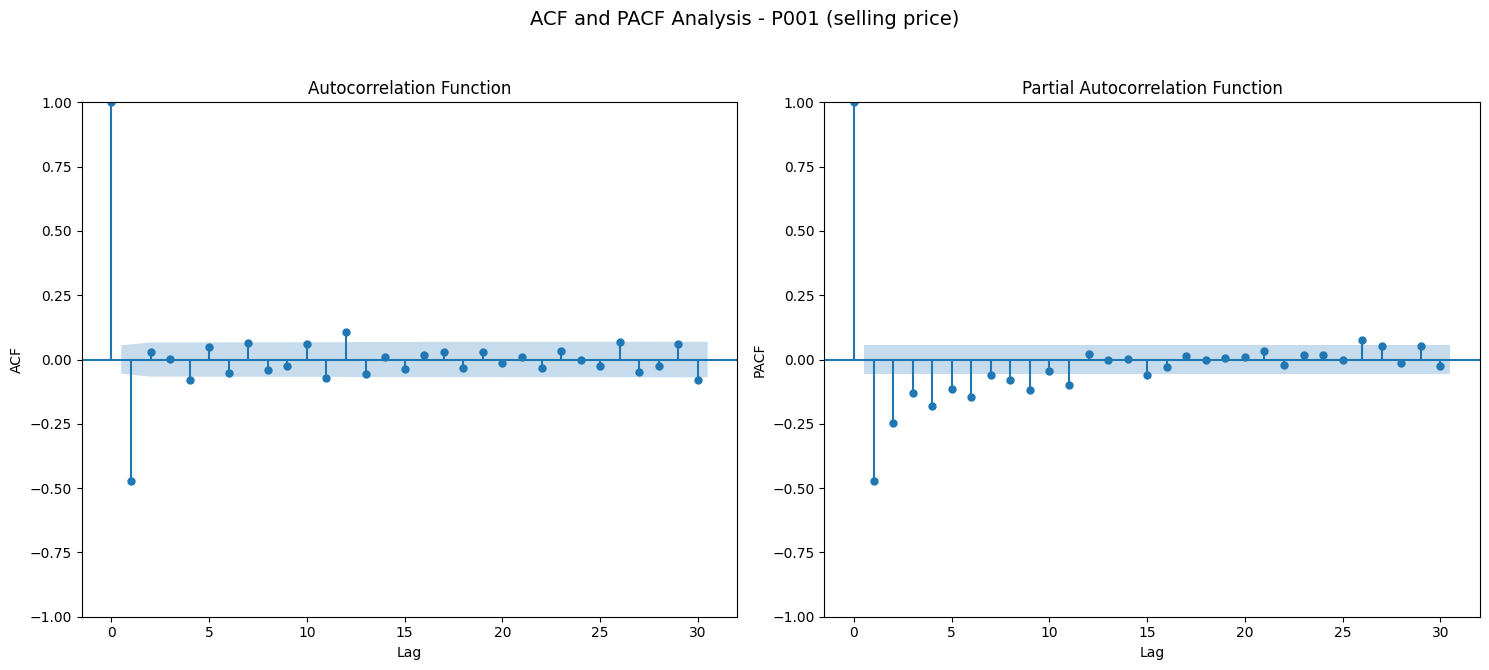


Suggested ARIMA parameters for P001 - selling price:
p (AR order) suggestion: 5
q (MA order) suggestion: 5


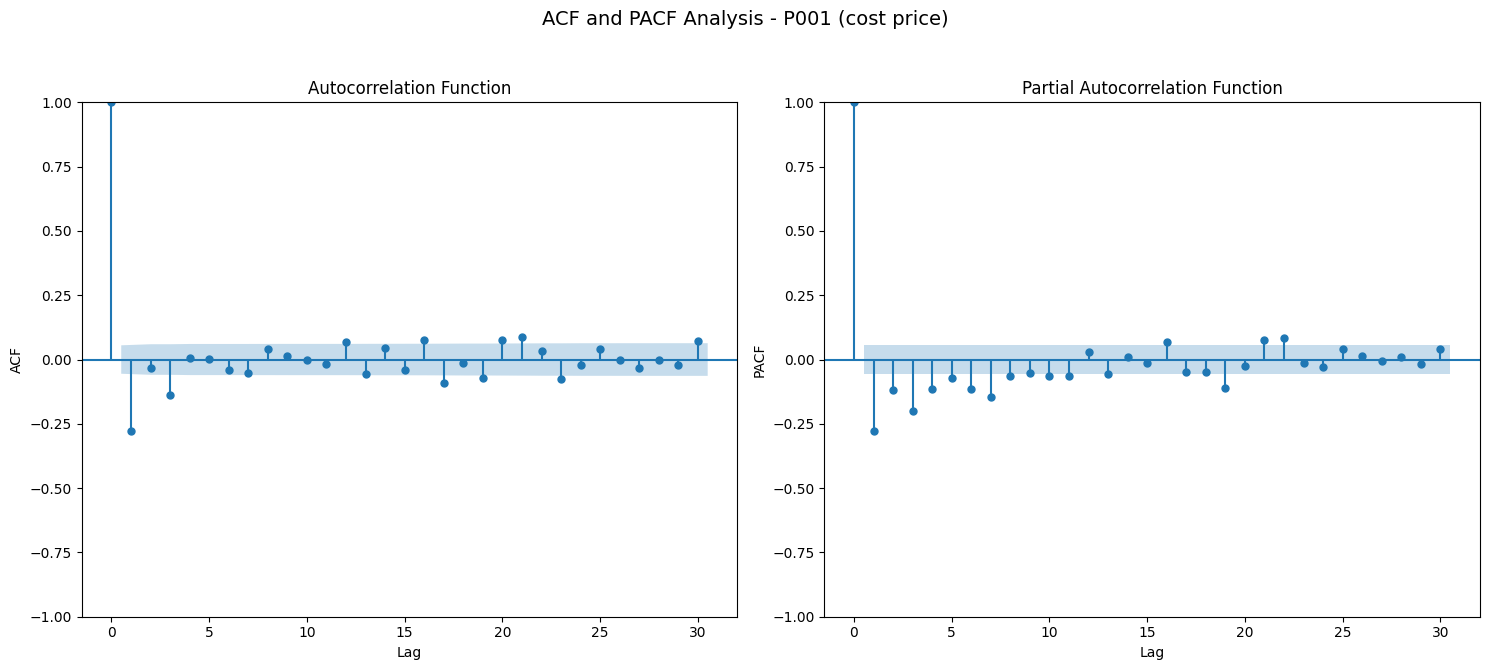


Suggested ARIMA parameters for P001 - cost price:
p (AR order) suggestion: 5
q (MA order) suggestion: 5

Analyzing P002


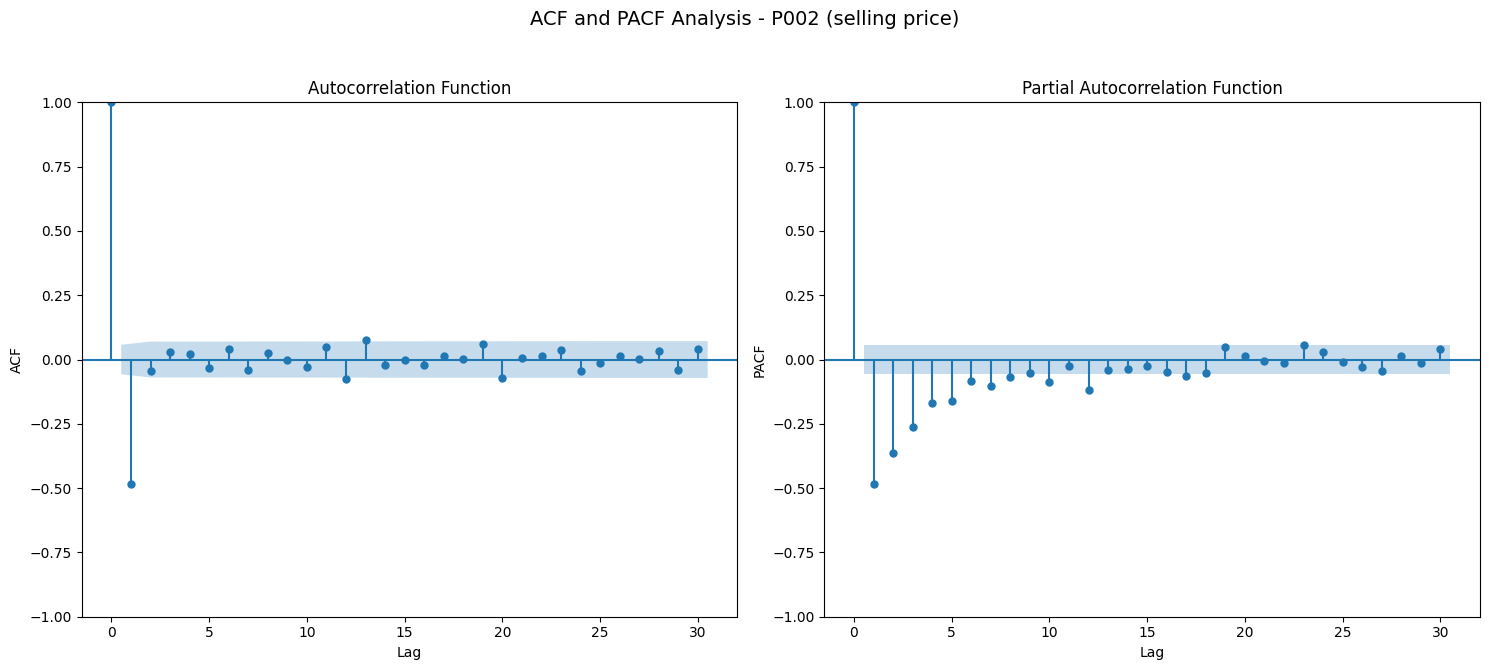


Suggested ARIMA parameters for P002 - selling price:
p (AR order) suggestion: 5
q (MA order) suggestion: 5


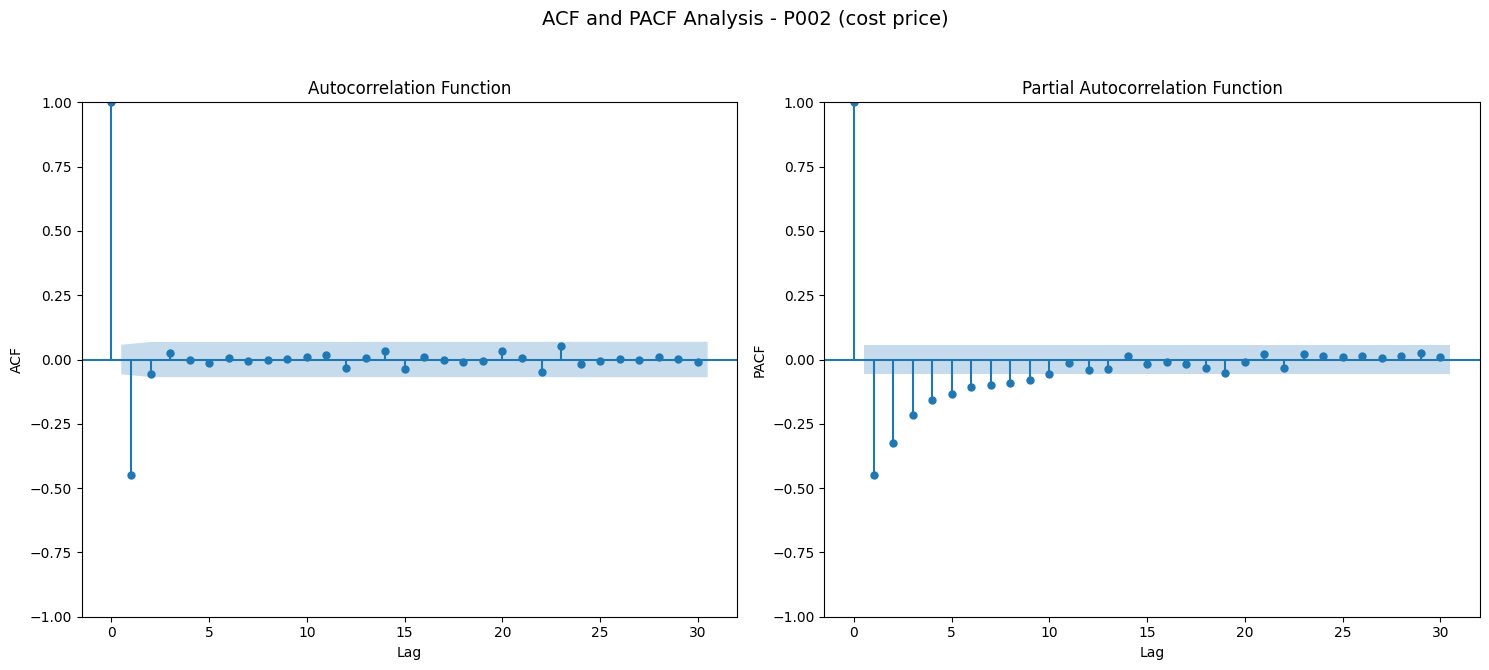


Suggested ARIMA parameters for P002 - cost price:
p (AR order) suggestion: 5
q (MA order) suggestion: 1

Analyzing P003


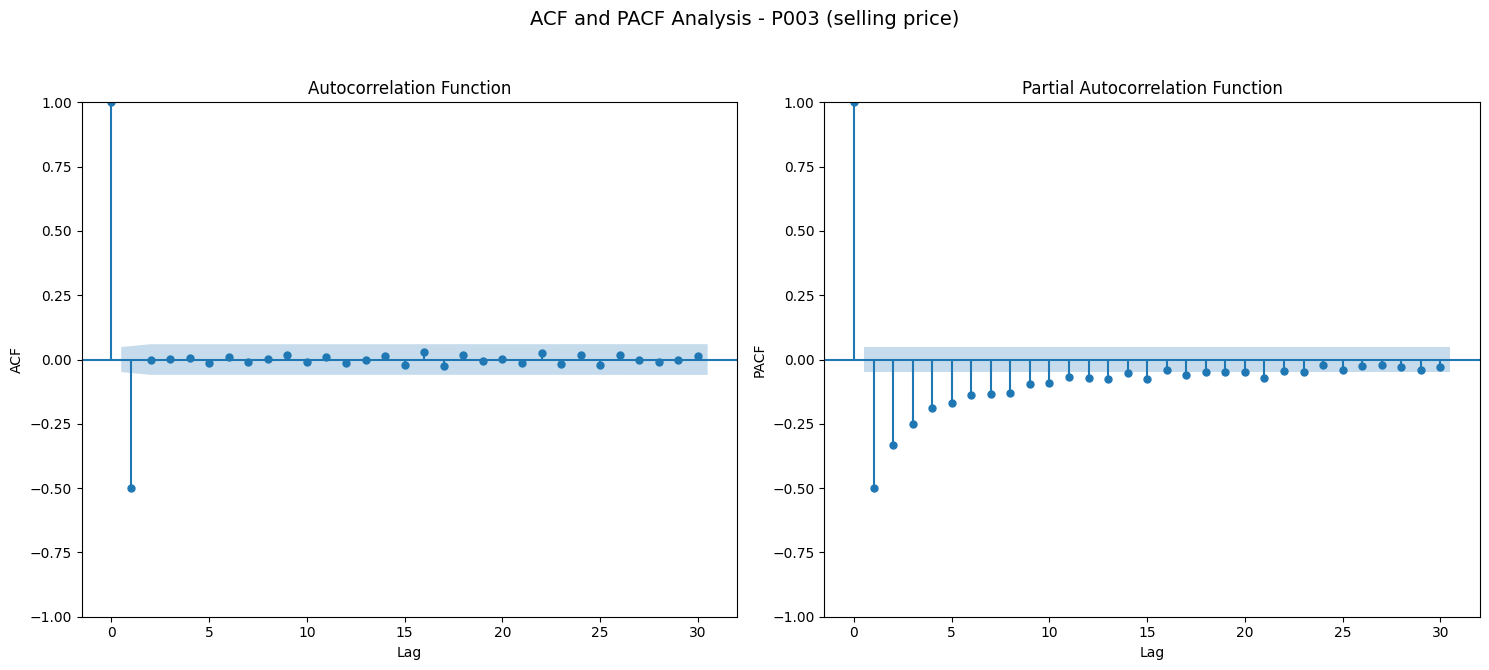


Suggested ARIMA parameters for P003 - selling price:
p (AR order) suggestion: 5
q (MA order) suggestion: 1


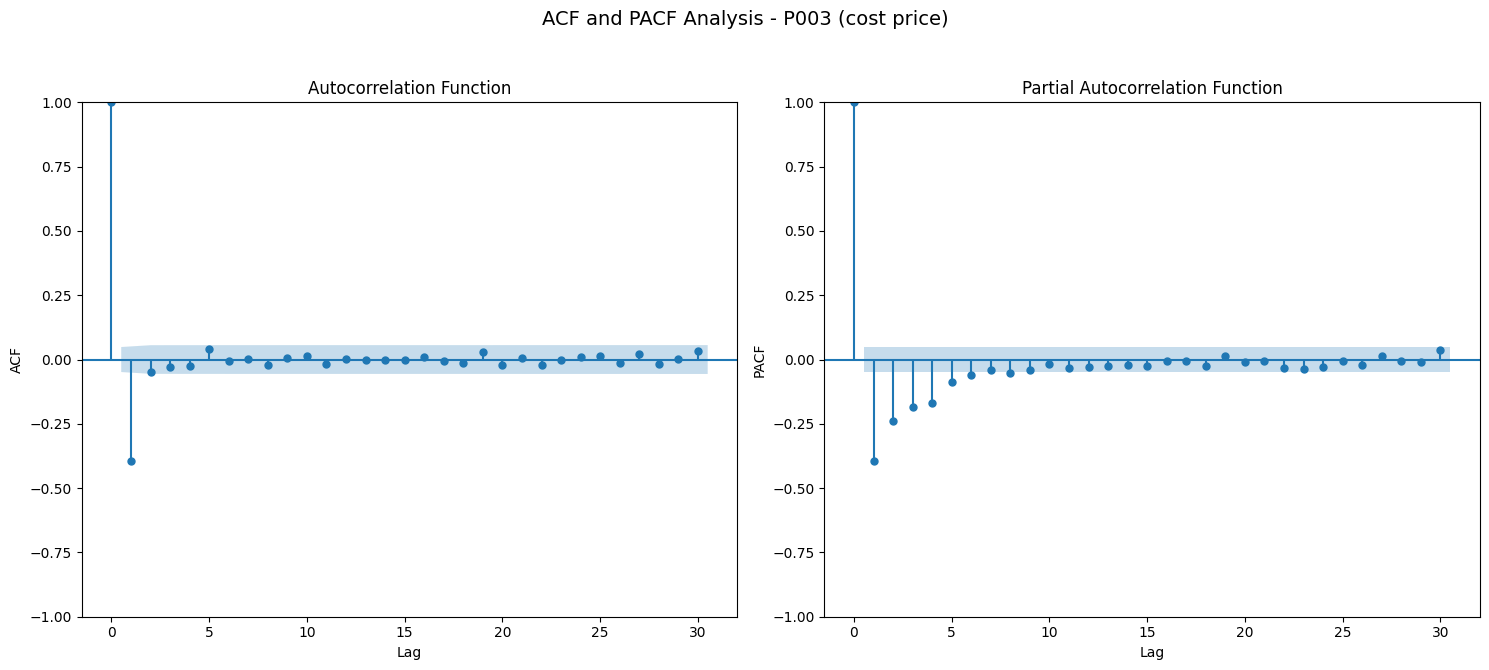


Suggested ARIMA parameters for P003 - cost price:
p (AR order) suggestion: 5
q (MA order) suggestion: 1

Analyzing P004


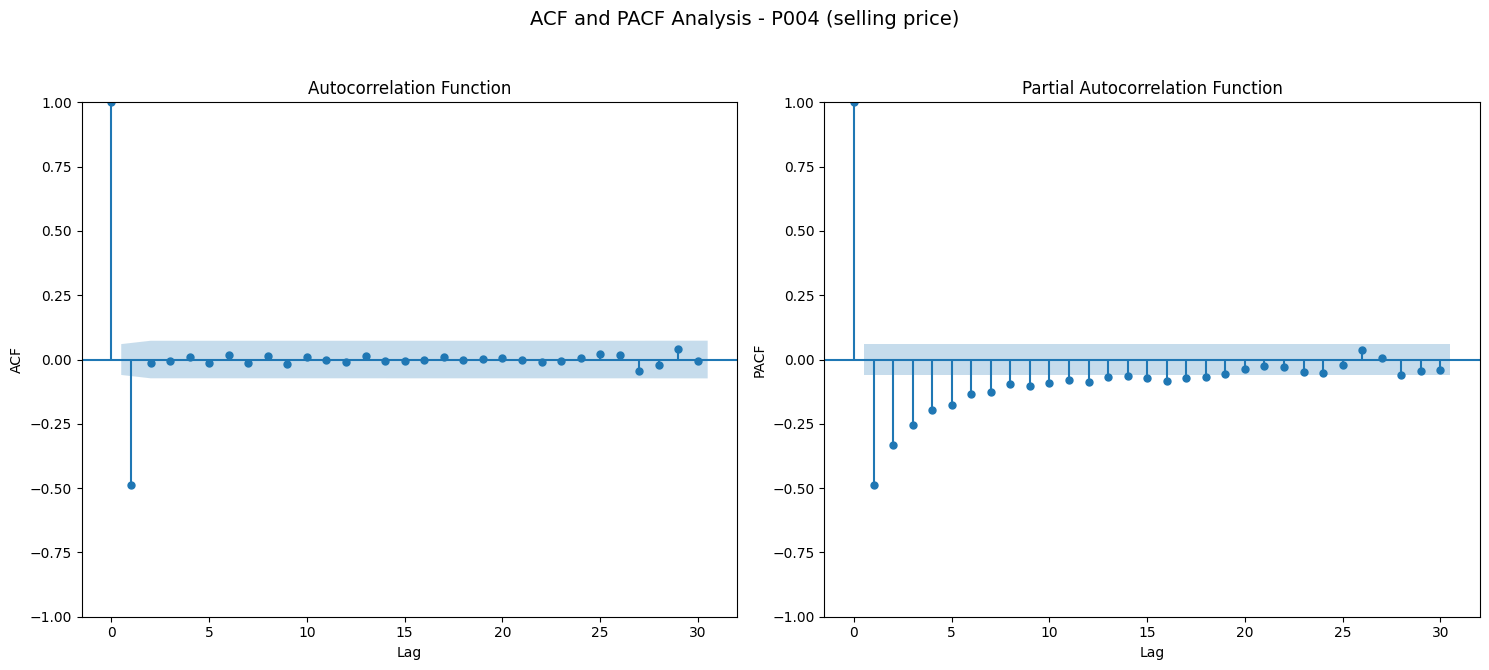


Suggested ARIMA parameters for P004 - selling price:
p (AR order) suggestion: 5
q (MA order) suggestion: 1


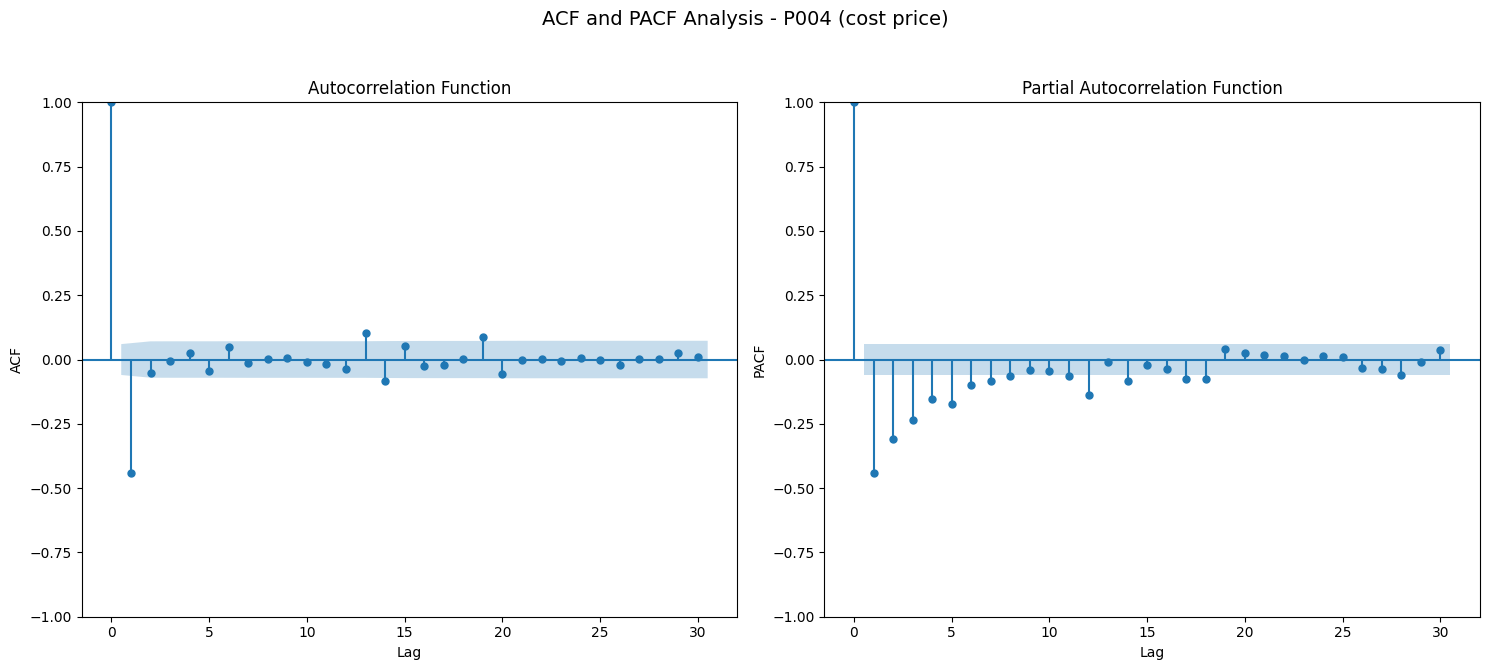


Suggested ARIMA parameters for P004 - cost price:
p (AR order) suggestion: 5
q (MA order) suggestion: 4

Analyzing P007


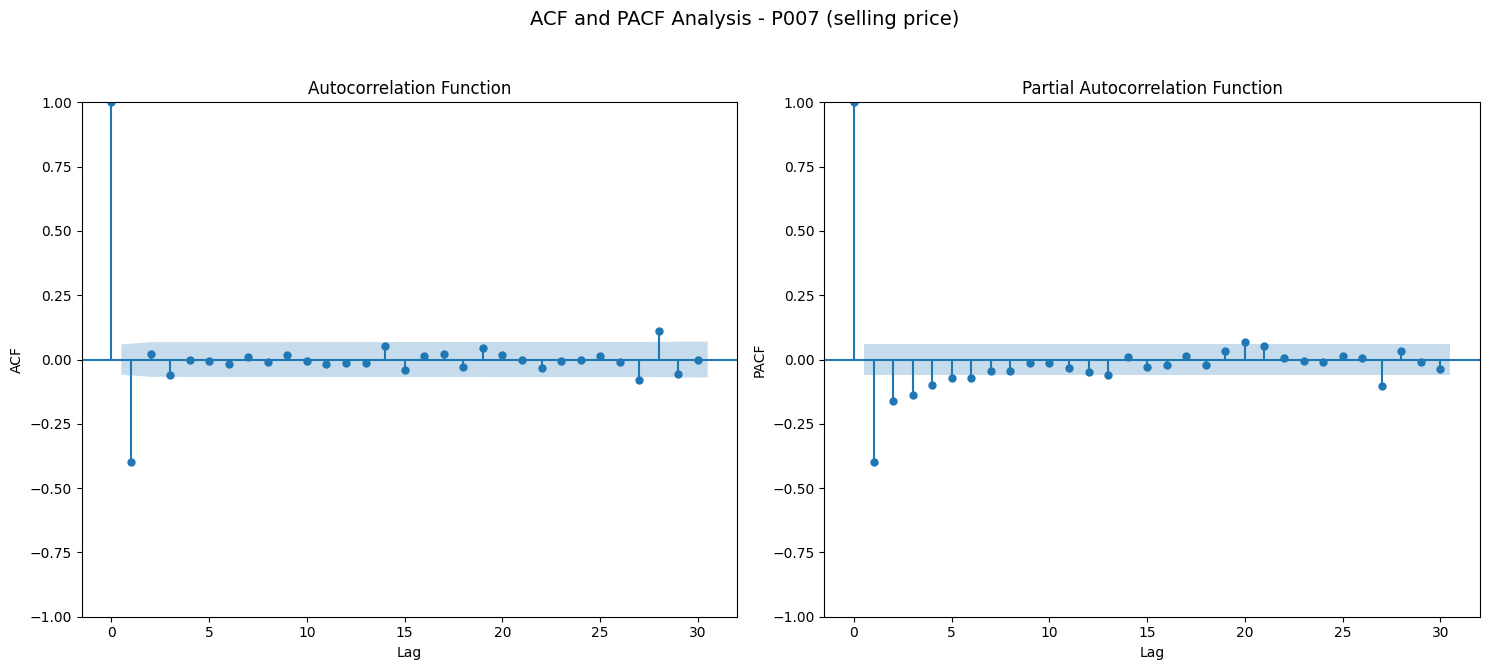


Suggested ARIMA parameters for P007 - selling price:
p (AR order) suggestion: 5
q (MA order) suggestion: 3


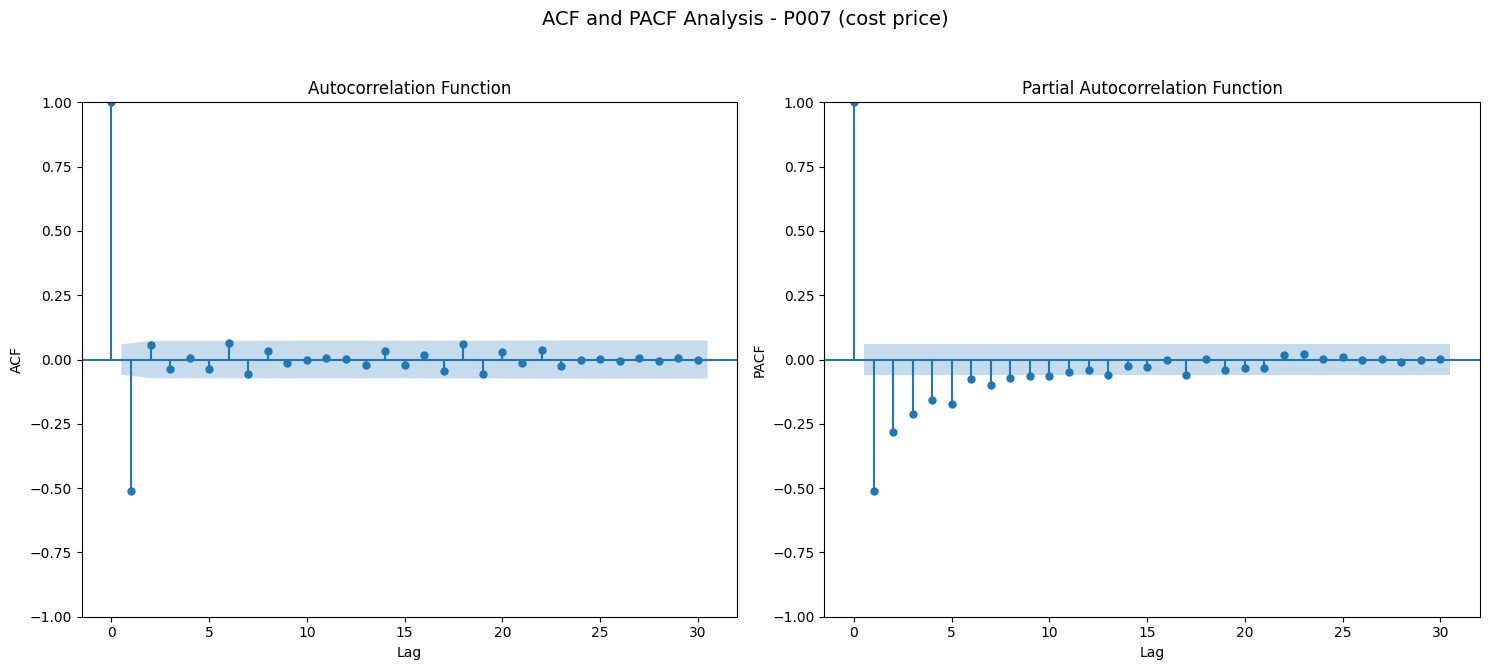


Suggested ARIMA parameters for P007 - cost price:
p (AR order) suggestion: 5
q (MA order) suggestion: 3

Analyzing P012


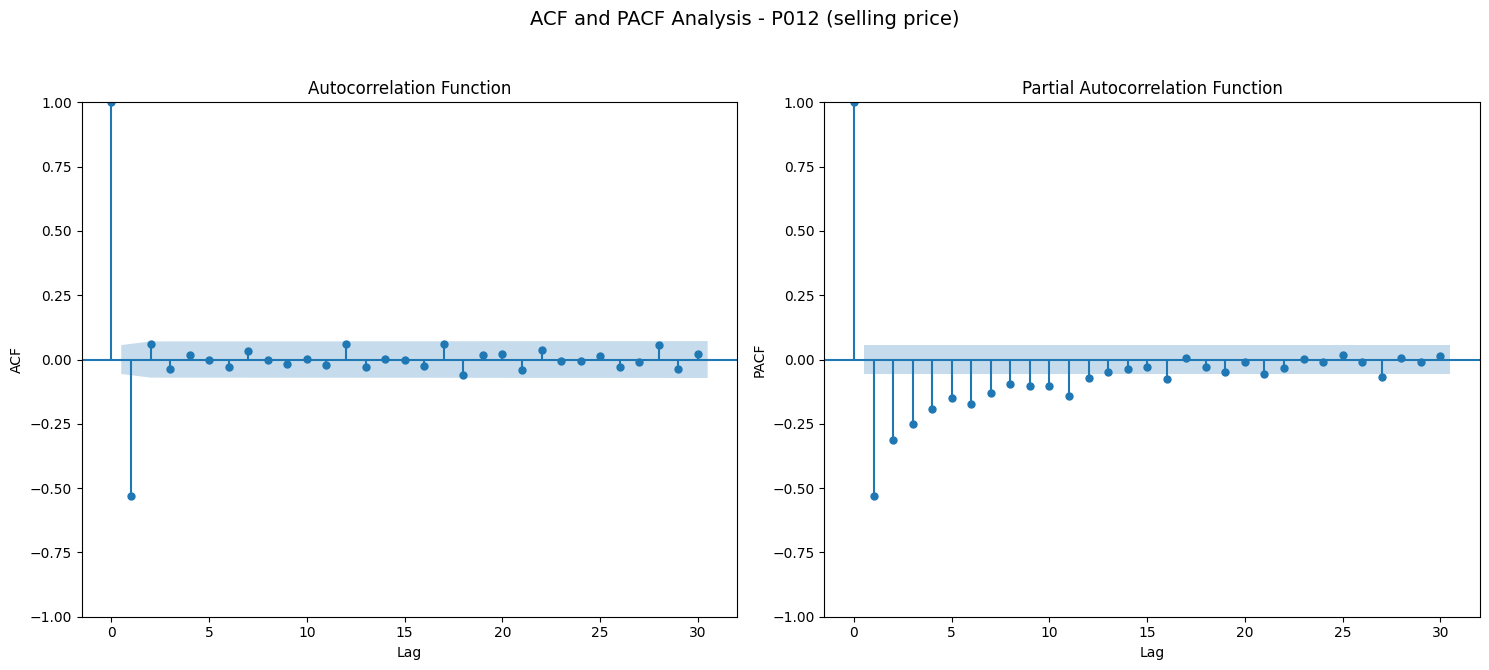


Suggested ARIMA parameters for P012 - selling price:
p (AR order) suggestion: 5
q (MA order) suggestion: 5


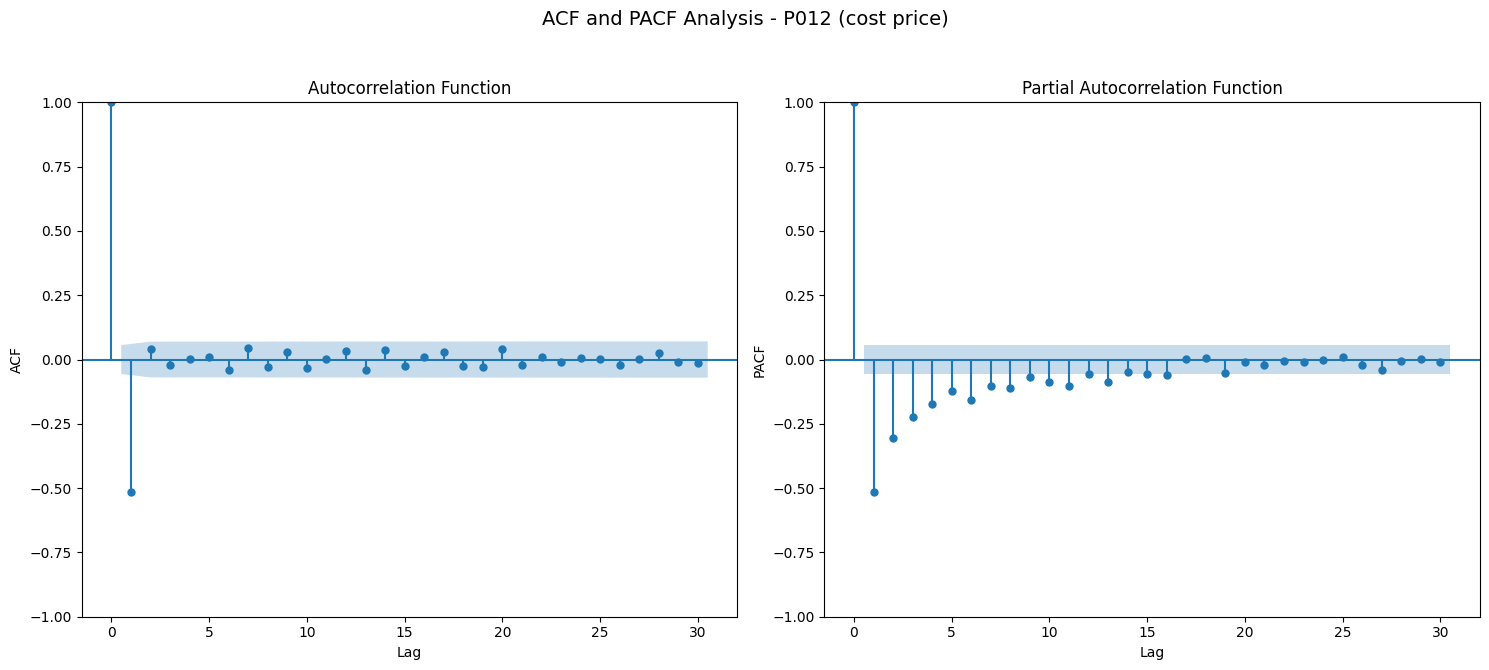


Suggested ARIMA parameters for P012 - cost price:
p (AR order) suggestion: 5
q (MA order) suggestion: 1


In [17]:
# Store ARIMA parameters for each product and price type
arima_params = {
    'selling': {},
    'cost': {}
}

# Analyze each product's time series
for product_id in products:
    print(f"\n{'='*50}")
    print(f"Analyzing {product_id}")
    print('='*50)
    
    # Analyze selling price
    arima_params['selling'][product_id] = analyze_acf_pacf(
        price_arrays['selling'][product_id],
        product_id,
        'selling'
    )
    
    # Analyze cost price
    arima_params['cost'][product_id] = analyze_acf_pacf(
        price_arrays['cost'][product_id],
        product_id,
        'cost'
    )

In [18]:
# Summary of suggested ARIMA parameters
print("Summary of Suggested ARIMA Parameters:")
print("====================================")
for price_type in ['selling', 'cost']:
    print(f"\n{price_type.capitalize()} Price Models:")
    print("-" * 30)
    for product_id in products:
        params = arima_params[price_type][product_id]
        print(f"{product_id}: ARIMA(p={params['p']}, d=0, q={params['q']})")

Summary of Suggested ARIMA Parameters:

Selling Price Models:
------------------------------
P001: ARIMA(p=5, d=1, q=5)
P002: ARIMA(p=5, d=1, q=5)
P003: ARIMA(p=5, d=1, q=1)
P004: ARIMA(p=5, d=1, q=1)
P007: ARIMA(p=5, d=1, q=3)
P012: ARIMA(p=5, d=1, q=5)

Cost Price Models:
------------------------------
P001: ARIMA(p=5, d=1, q=5)
P002: ARIMA(p=5, d=1, q=1)
P003: ARIMA(p=5, d=1, q=1)
P004: ARIMA(p=5, d=1, q=4)
P007: ARIMA(p=5, d=1, q=3)
P012: ARIMA(p=5, d=1, q=1)


#### ARIMA parameter optimization

In [25]:
def optimize_arima_params(data, max_order=7):
    """Find optimal ARIMA parameters by minimizing AIC"""
    best_aic = float('inf')
    best_params = None
    
    for p in range(max_order + 1):
        for q in range(max_order + 1):
            try:
                model = ARIMA(data, order=(p, 0, q))
                results = model.fit()
                
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_params = (p, 0, q)
            except:
                continue
    
    return best_params, best_aic

def optimize_arimax_params(endog, exog, max_order=7):
    """Find optimal ARIMAX parameters by minimizing AIC"""
    best_aic = float('inf')
    best_params = None
    
    for p in range(max_order + 1):
        for q in range(max_order + 1):
            try:
                model = SARIMAX(endog, exog=exog, order=(p, 0, q))
                results = model.fit(disp=False)
                
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_params = (p, 0, q)
            except:
                continue
    
    return best_params, best_aic

In [26]:
# Dictionary to store optimal parameters
optimal_params = {
    'cost': {},    # Store cost price ARIMA parameters
    'selling': {}  # Store selling price ARIMAX parameters
}

# Optimize parameters for each product
for product_id in products:
    print(f"\nOptimizing parameters for {product_id}")
    print("=" * 50)
    
    # 1. Optimize ARIMA for cost price
    cost_data = price_arrays['cost'][product_id]
    cost_params, cost_aic = optimize_arima_params(cost_data)
    
    # Store cost price model parameters
    optimal_params['cost'][product_id] = {
        'order': cost_params,
        'aic': cost_aic
    }
    
    print(f"Cost Price ARIMA: {cost_params} (AIC: {cost_aic:.2f})")
    
    # 2. Fit cost price model to get predictions for ARIMAX
    cost_model = ARIMA(cost_data, order=cost_params)
    cost_fit = cost_model.fit()
    cost_predictions = cost_fit.fittedvalues
    
    # 3. Optimize ARIMAX for selling price using cost predictions as exog
    sell_data = price_arrays['selling'][product_id]
    sell_params, sell_aic = optimize_arimax_params(sell_data, exog=cost_predictions.reshape(-1, 1))
    
    # Store selling price model parameters
    optimal_params['selling'][product_id] = {
        'order': sell_params,
        'aic': sell_aic
    }
    
    print(f"Selling Price ARIMAX: {sell_params} (AIC: {sell_aic:.2f})")

# Save optimal parameters
params_file = os.path.join(data_dir_path, 'optimal_arima_params.joblib')
joblib.dump(optimal_params, params_file)

# Print summary
print("\nOptimal ARIMA Parameters Summary:")
print("================================")
for product_id in products:
    print(f"\nProduct: {product_id}")
    print(f"Cost Price ARIMA{optimal_params['cost'][product_id]['order']}")
    print(f"Selling Price ARIMAX{optimal_params['selling'][product_id]['order']}")


Optimizing parameters for P001
Cost Price ARIMA: (4, 0, 3) (AIC: 10424.16)
Cost Price ARIMA: (4, 0, 3) (AIC: 10424.16)
Selling Price ARIMAX: (7, 0, 6) (AIC: 11425.52)

Optimizing parameters for P002
Selling Price ARIMAX: (7, 0, 6) (AIC: 11425.52)

Optimizing parameters for P002
Cost Price ARIMA: (1, 0, 6) (AIC: 7008.15)
Cost Price ARIMA: (1, 0, 6) (AIC: 7008.15)
Selling Price ARIMAX: (3, 0, 5) (AIC: 7838.00)

Optimizing parameters for P003
Selling Price ARIMAX: (3, 0, 5) (AIC: 7838.00)

Optimizing parameters for P003
Cost Price ARIMA: (1, 0, 1) (AIC: 10798.75)
Cost Price ARIMA: (1, 0, 1) (AIC: 10798.75)
Selling Price ARIMAX: (0, 0, 1) (AIC: 18553.87)

Optimizing parameters for P004
Selling Price ARIMAX: (0, 0, 1) (AIC: 18553.87)

Optimizing parameters for P004
Cost Price ARIMA: (5, 0, 6) (AIC: 10344.29)
Cost Price ARIMA: (5, 0, 6) (AIC: 10344.29)
Selling Price ARIMAX: (3, 0, 4) (AIC: 12796.72)

Optimizing parameters for P007
Selling Price ARIMAX: (3, 0, 4) (AIC: 12796.72)

Optimizing 

#### Model prediction visualization

In [27]:
def plot_model_fit(actual, predicted, product_id, price_type, title):
    """Plot actual vs predicted values with error bands"""
    plt.figure(figsize=(15, 6))
    
    # Calculate error metrics
    mse = mean_squared_error(actual, predicted)
    rmse = sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    
    # Create the plot
    plt.plot(actual.index, actual, 'b-', label='Actual', alpha=0.6)
    plt.plot(predicted.index, predicted, 'r--', label='Predicted', alpha=0.8)
    
    # Add confidence bands (±2*RMSE)
    plt.fill_between(
        predicted.index,
        predicted - 2*rmse,
        predicted + 2*rmse,
        color='r',
        alpha=0.1,
        label='95% Confidence'
    )
    
    plt.title(f'{title}\nProduct: {product_id} - {price_type} Price\nRMSE: {rmse:.2f}, MAE: {mae:.2f}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Visualizing predictions for P001


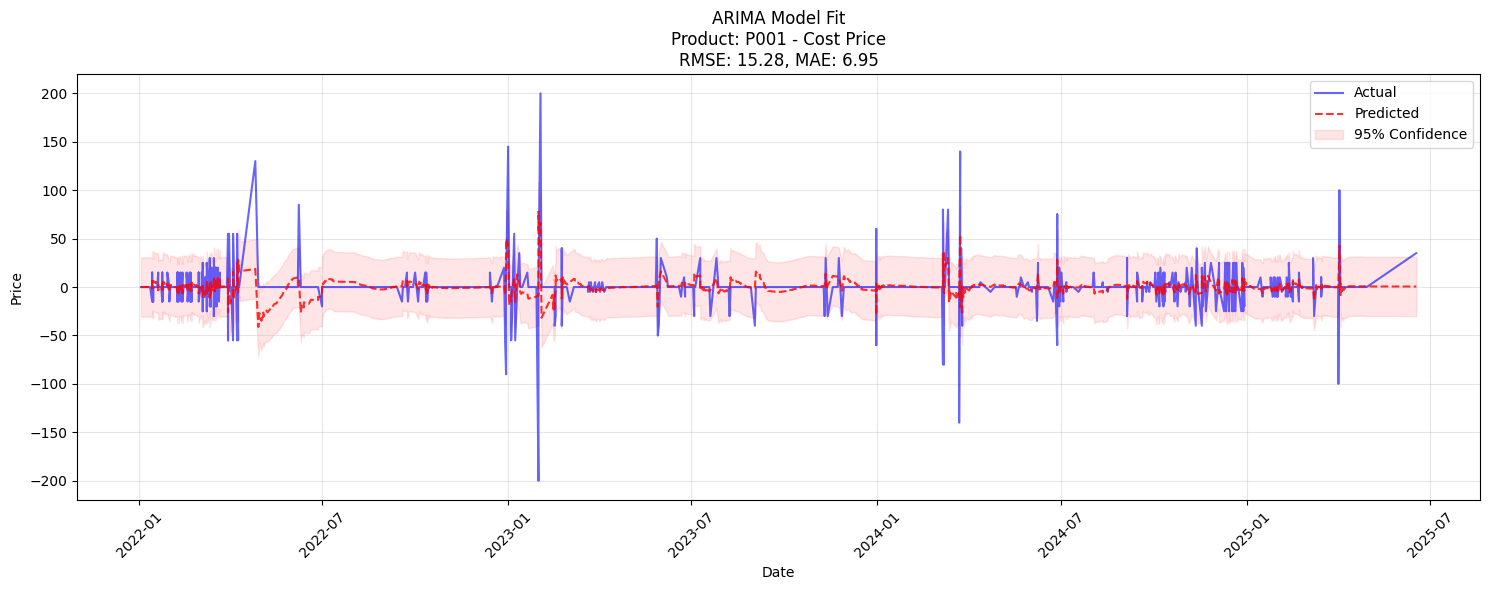

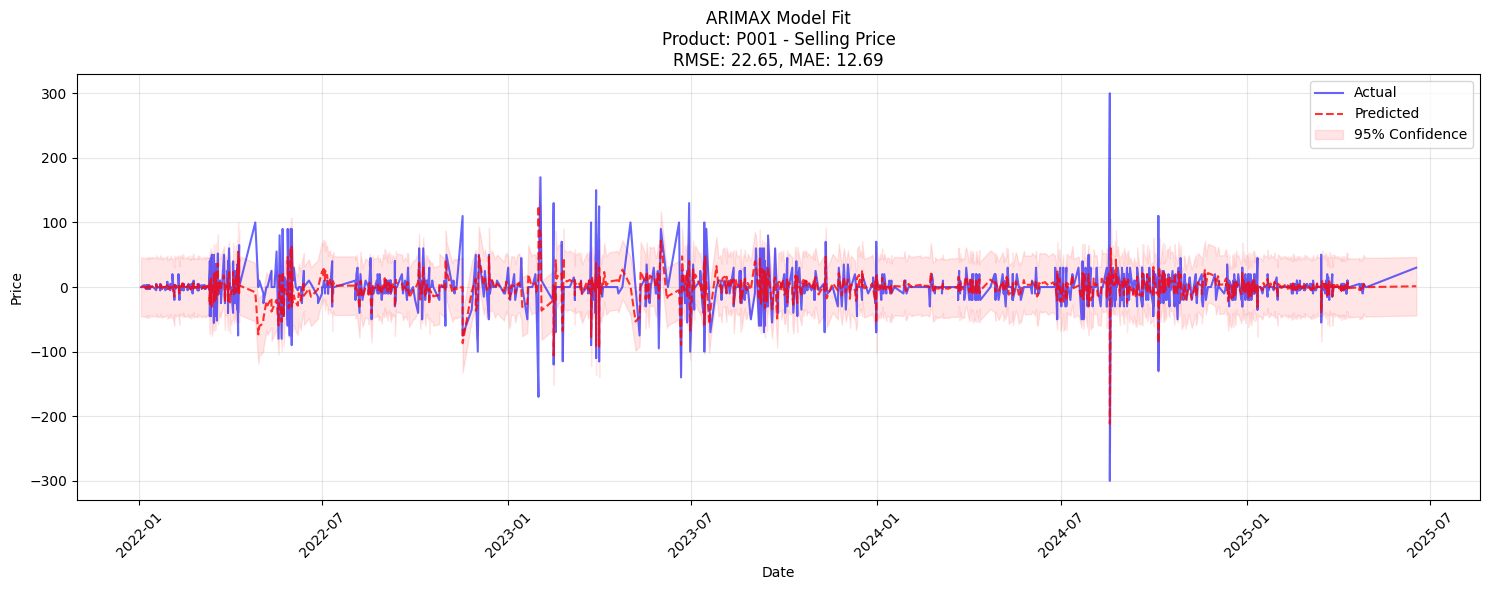


Visualizing predictions for P002


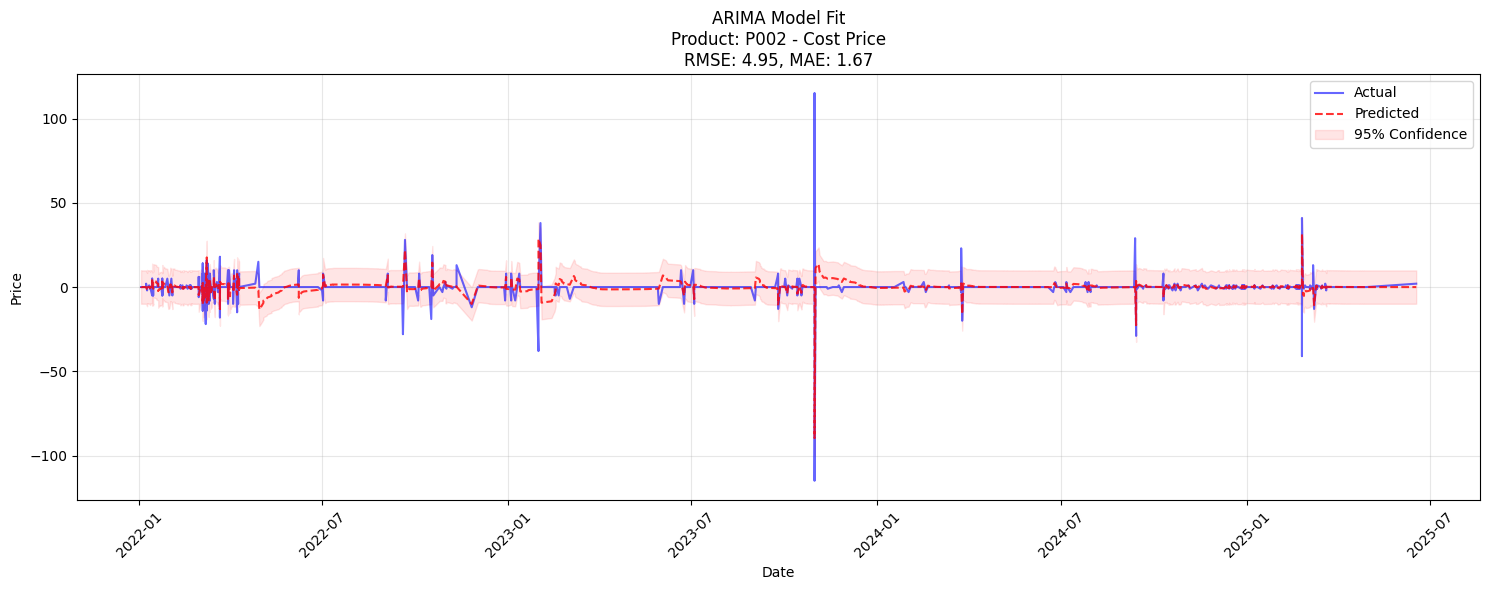

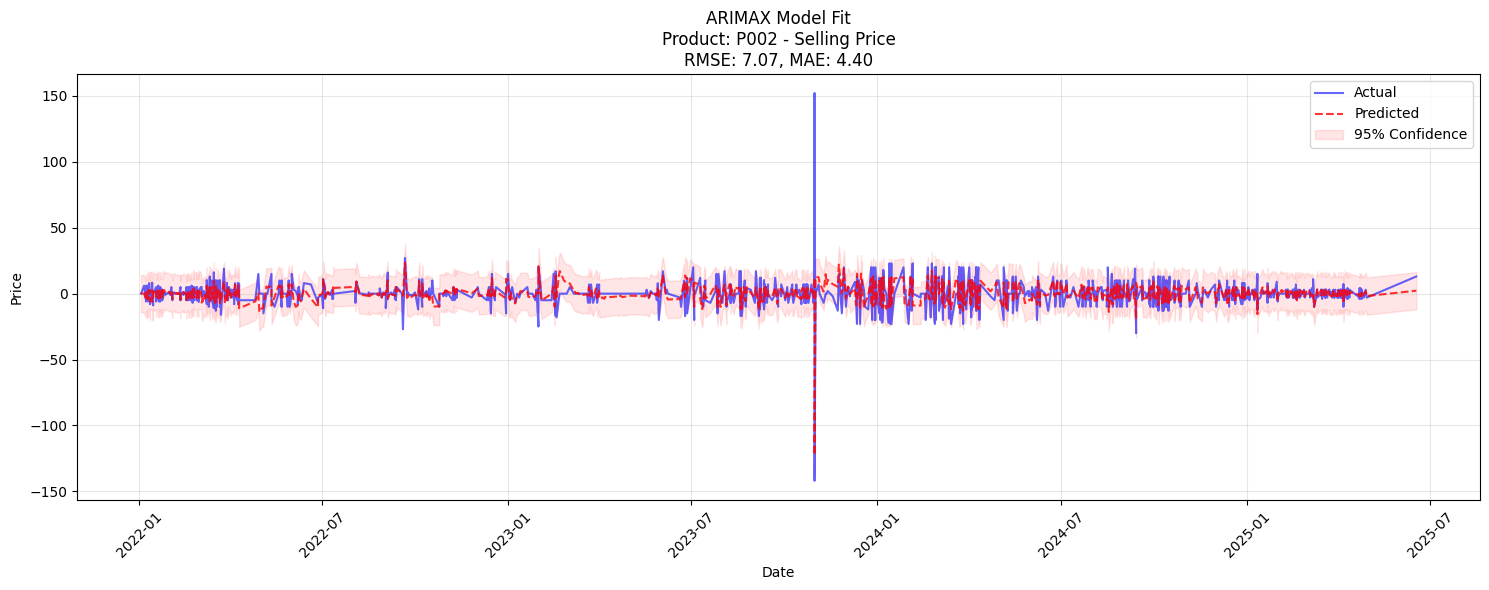


Visualizing predictions for P003


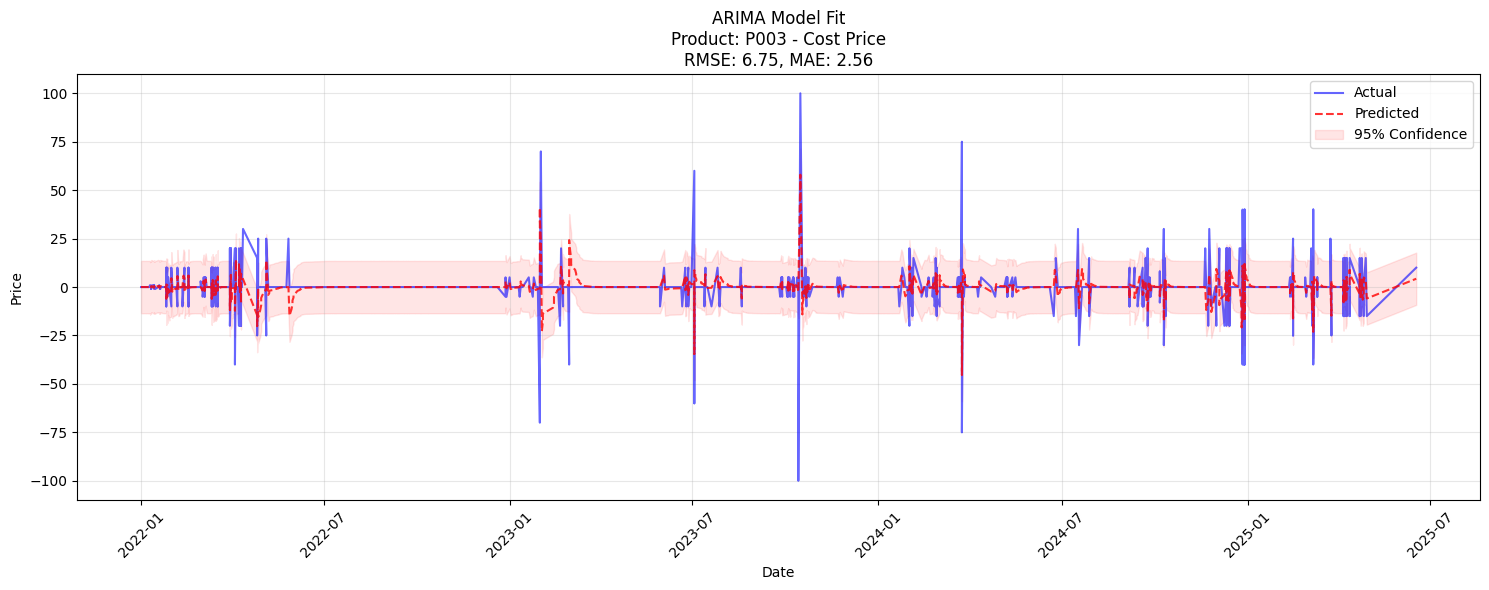

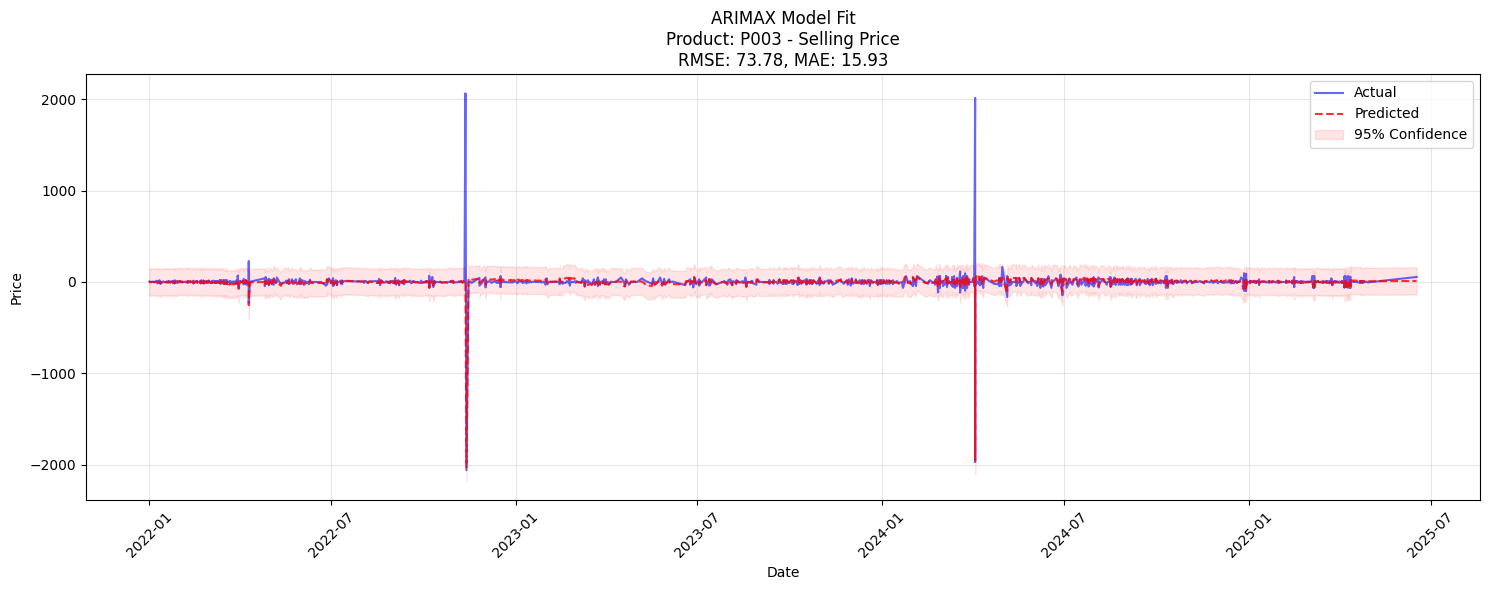


Visualizing predictions for P004


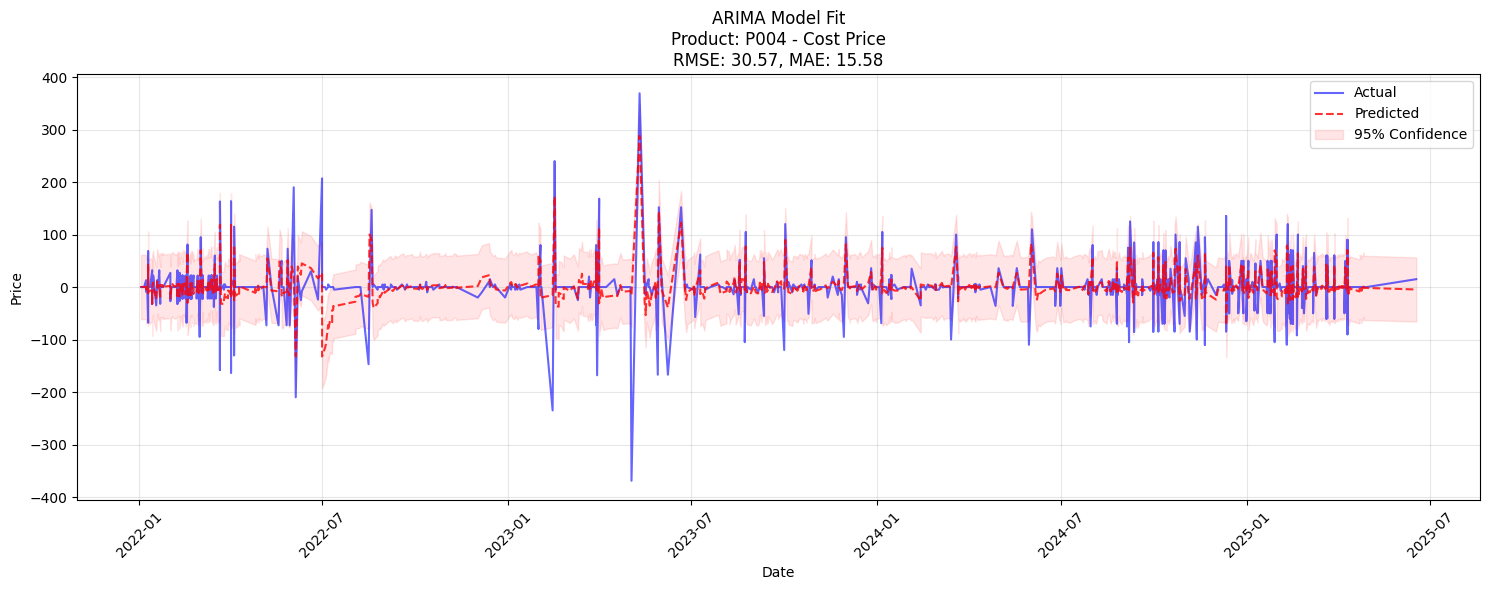

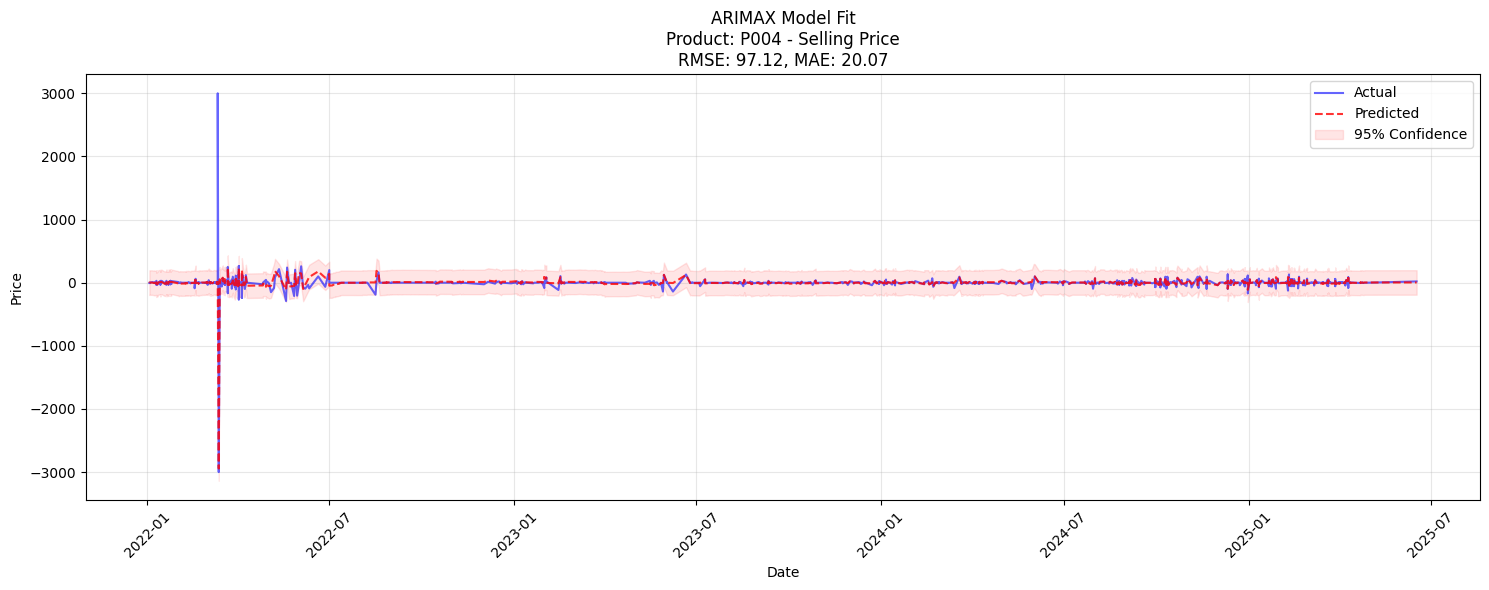


Visualizing predictions for P007


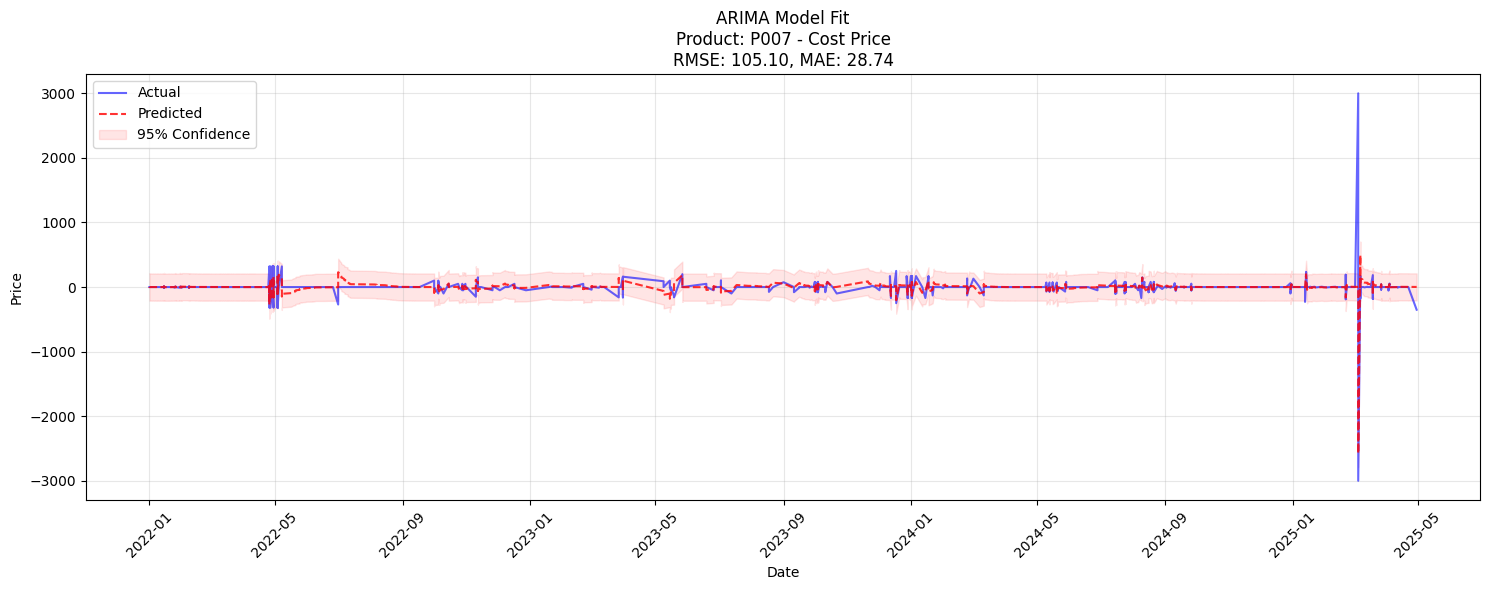

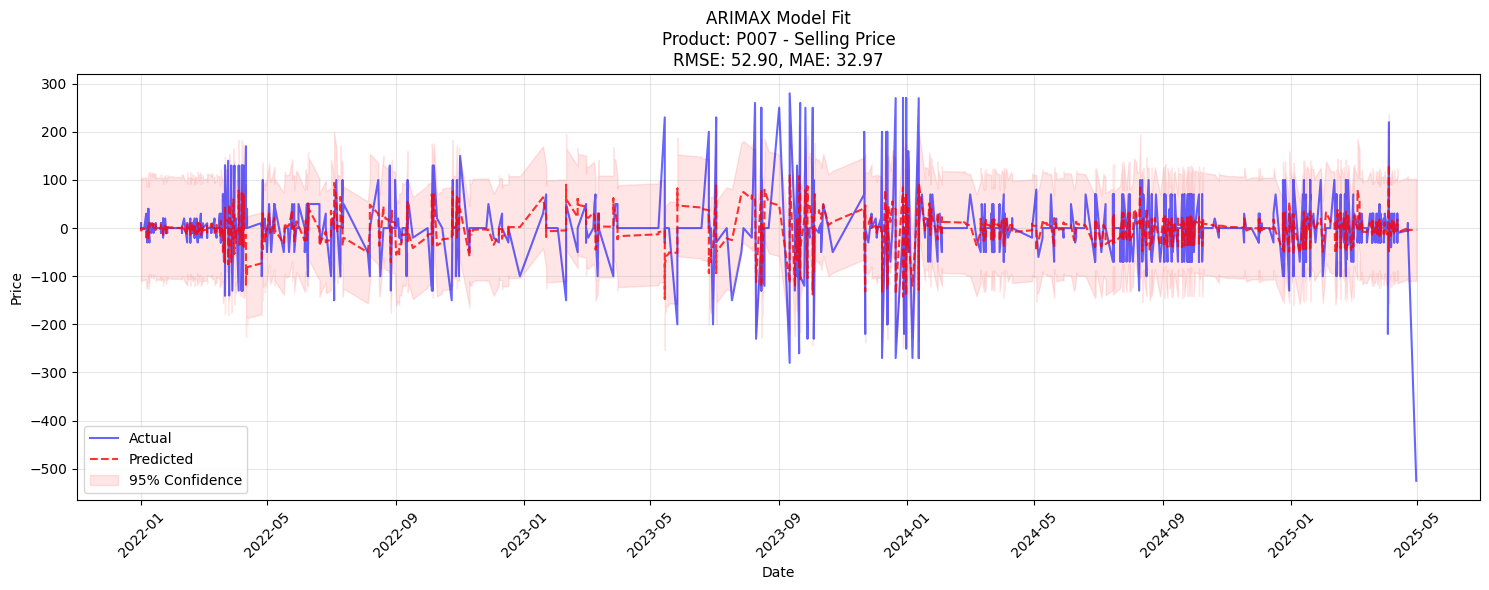


Visualizing predictions for P012


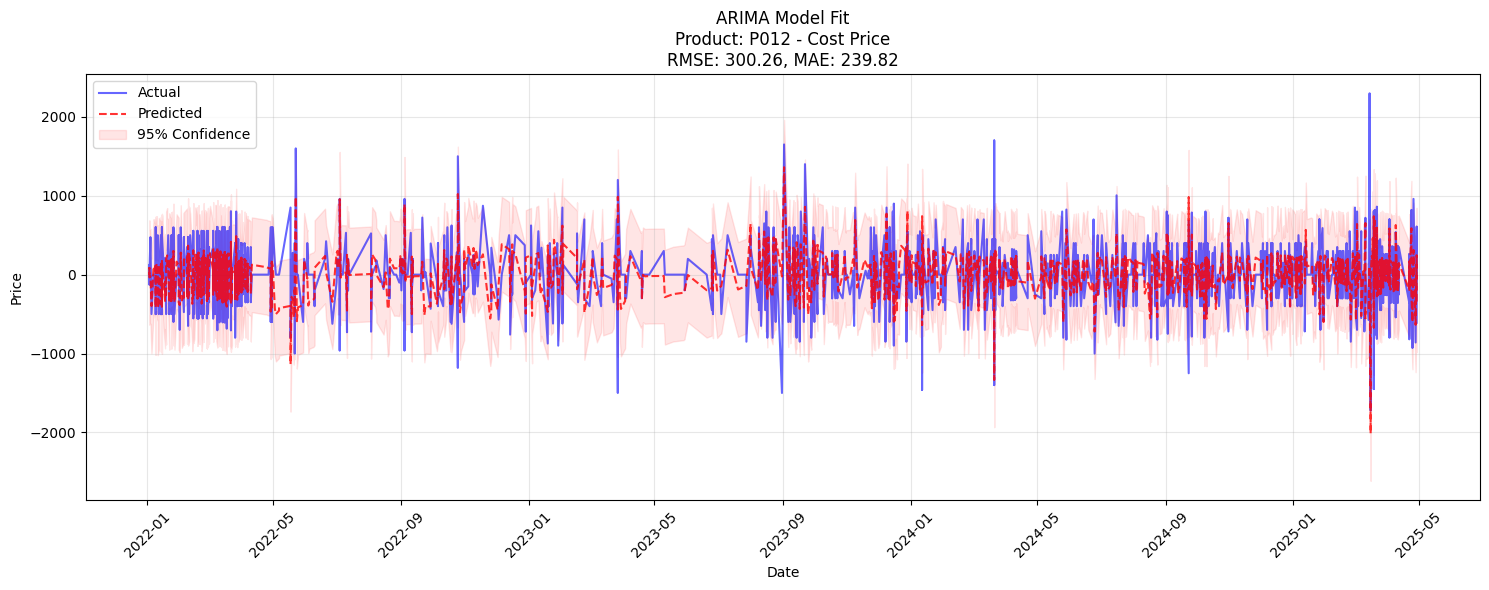

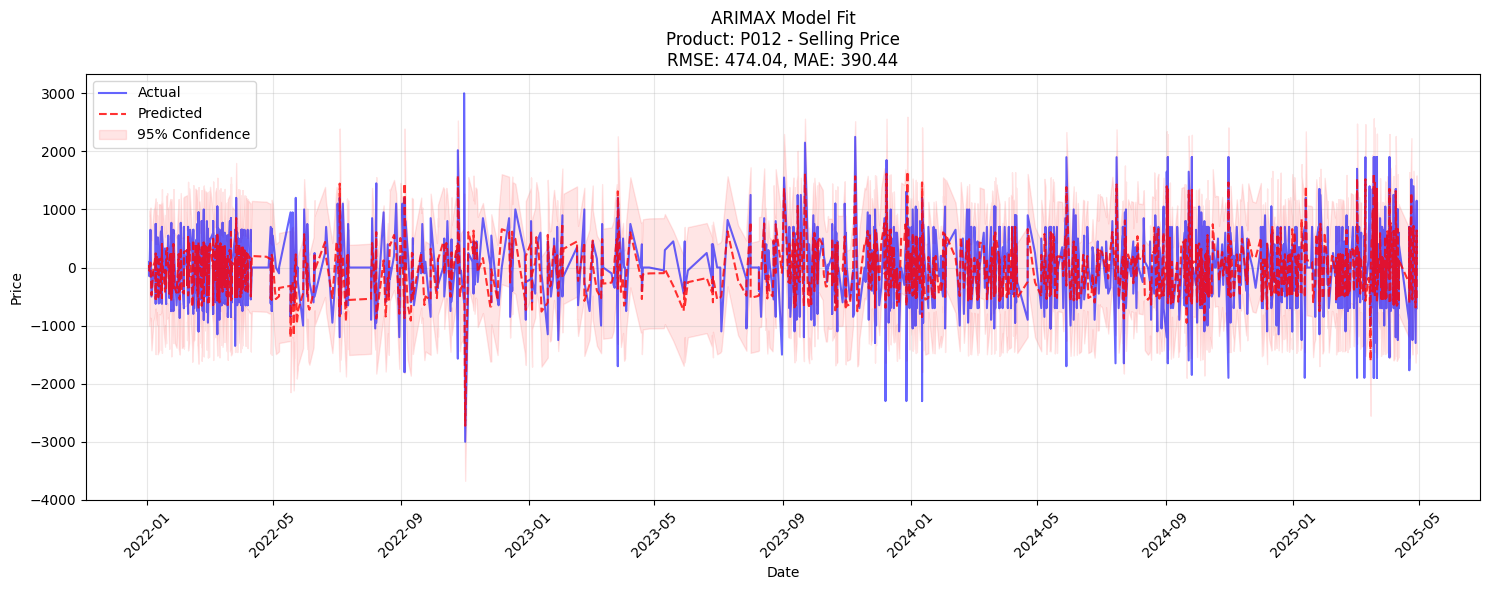

In [28]:
# Fit models and visualize predictions
fitted_models = {'cost': {}, 'selling': {}}

for product_id in products:
    print(f"\nVisualizing predictions for {product_id}")
    print("=" * 50)
    
    # 1. Cost Price Model
    cost_data = price_arrays['cost'][product_id]
    cost_order = optimal_params['cost'][product_id]['order']
    
    cost_model = ARIMA(cost_data, order=cost_order)
    cost_fit = cost_model.fit()
    fitted_models['cost'][product_id] = cost_fit
    
    # Get cost predictions
    cost_pred = pd.Series(
        cost_fit.fittedvalues,
        index=time_indices[product_id]
    )
    cost_actual = pd.Series(
        cost_data,
        index=time_indices[product_id]
    )
    
    # Plot cost price predictions
    plot_model_fit(
        cost_actual,
        cost_pred,
        product_id,
        'Cost',
        'ARIMA Model Fit'
    )
    
    # 2. Selling Price Model
    sell_data = price_arrays['selling'][product_id]
    sell_order = optimal_params['selling'][product_id]['order']
    
    # Use cost predictions as exogenous variable
    sell_model = SARIMAX(
        sell_data,
        exog=cost_pred.values.reshape(-1, 1),
        order=sell_order
    )
    sell_fit = sell_model.fit(disp=False)
    fitted_models['selling'][product_id] = sell_fit
    
    # Get selling predictions
    sell_pred = pd.Series(
        sell_fit.fittedvalues,
        index=time_indices[product_id]
    )
    sell_actual = pd.Series(
        sell_data,
        index=time_indices[product_id]
    )
    
    # Plot selling price predictions
    plot_model_fit(
        sell_actual,
        sell_pred,
        product_id,
        'Selling',
        'ARIMAX Model Fit'
    )

#### Saving best models fitted

In [29]:
models_file = os.path.join('../../models', 'fitted_models.joblib')
joblib.dump(fitted_models, models_file)

['../../models\\fitted_models.joblib']